# Assignment lab 05
- 19.04.21

## Master Class: Machine Learning (5MI2018)
- Faculty of Economic Science
- University of Neuchatel (Switzerland)
- Lab 5, see ML21_Exercise_5.pdf for more information

## Authors: 
- Romain Claret @RomainClaret
- Sylvain Robert-Nicoud @Nic0uds

| Variable   name                                    | Variable definition                                                                                                                                                                                                              |
|----------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Identifier variables                               |                                                                                                                                                                                                                                  |
| countrycode                                        | 3-letter ISO country code                                                                                                                                                                                                        |
| country                                            | Country name                                                                                                                                                                                                                     |
| currency_unit                                      | Currency unit                                                                                                                                                                                                                    |
| year                                               | Year                                                                                                                                                                                                                             |
|                                                    |                                                                                                                                                                                                                                  |
| Real   GDP, employment and population levels       |                                                                                                                                                                                                                                  |
| rgdpe                                              | Expenditure-side real GDP at   chained PPPs (in mil. 2017US$)                                                                                                                                                                    |
| rgdpo                                              | Output-side real GDP at chained   PPPs (in mil. 2017US$)                                                                                                                                                                         |
| pop                                                | Population (in millions)                                                                                                                                                                                                         |
| emp                                                | Number of persons engaged (in   millions)                                                                                                                                                                                        |
| avh                                                | Average annual hours worked by   persons engaged                                                                                                                                                                                 |
| hc                                                 | Human capital index, based on   years of schooling and returns to education; see Human capital in PWT9.                                                                                                                          |
|                                                    |                                                                                                                                                                                                                                  |
| Current   price GDP, capital and TFP               |                                                                                                                                                                                                                                  |
| ccon                                               | Real consumption of households   and government, at current PPPs (in mil. 2017US$)                                                                                                                                               |
| cda                                                | Real domestic absorption, (real   consumption plus investment), at current PPPs (in mil. 2017US$)                                                                                                                                |
| cgdpe                                              | Expenditure-side real GDP at   current PPPs (in mil. 2017US$)                                                                                                                                                                    |
| cgdpo                                              | Output-side real GDP at current   PPPs (in mil. 2017US$)                                                                                                                                                                         |
| cn                                                 | Capital stock at current PPPs   (in mil. 2017US$)                                                                                                                                                                                |
| ck                                                 | Capital services levels at   current PPPs (USA=1)                                                                                                                                                                                |
| ctfp                                               | TFP level at current PPPs (USA=1)                                                                                                                                                                                                |
| cwtfp                                              | Welfare-relevant TFP levels at   current PPPs (USA=1)                                                                                                                                                                            |
|                                                    |                                                                                                                                                                                                                                  |
| National   accounts-based variables                |                                                                                                                                                                                                                                  |
| rgdpna                                             | Real GDP at constant 2017   national prices (in mil. 2017US$)                                                                                                                                                                    |
| rconna                                             | Real consumption at constant   2017 national prices (in mil. 2017US$)                                                                                                                                                            |
| rdana                                              | Real domestic absorption at   constant 2017 national prices (in mil. 2017US$)                                                                                                                                                    |
| rnna                                               | Capital stock at constant 2017   national prices (in mil. 2017US$)                                                                                                                                                               |
| rkna                                               | Capital services at constant   2017 national prices (2017=1)                                                                                                                                                                     |
| rtfpna                                             | TFP at constant national prices   (2017=1)                                                                                                                                                                                       |
| rwtfpna                                            | Welfare-relevant TFP at constant   national prices (2017=1)                                                                                                                                                                      |
| labsh                                              | Share of labour compensation in   GDP at current national prices                                                                                                                                                                 |
| irr                                                | Real internal rate of return                                                                                                                                                                                                     |
| delta                                              | Average depreciation rate of the   capital stock                                                                                                                                                                                 |
|                                                    |                                                                                                                                                                                                                                  |
| Exchange   rates and GDP price levels              |                                                                                                                                                                                                                                  |
| xr                                                 | Exchange rate, national   currency/USD (market+estimated)                                                                                                                                                                        |
| pl_con                                             | Price level of CCON (PPP/XR),   price level of USA GDPo in 2017=1                                                                                                                                                                |
| pl_da                                              | Price level of CDA (PPP/XR),   price level of USA GDPo in 2017=1                                                                                                                                                                 |
| pl_gdpo                                            | Price level of CGDPo (PPP/XR),   price level of USA GDPo in 2017=1                                                                                                                                                               |
|                                                    |                                                                                                                                                                                                                                  |
| Data information variables                         |                                                                                                                                                                                                                                  |
| i_cig                                              | 0/1/2/3/4: relative price data   for consumption, investment and government is extrapolated (0), benchmark   (1), interpolated (2), ICP PPP timeseries: benchmark or interpolated (3)   or  ICP PPP timeseries: extrapolated (4) |
| i_xm                                               | 0/1/2: relative price data for   exports and imports is extrapolated (0), benchmark (1) or interpolated (2)                                                                                                                      |
| i_xr                                               | 0/1: the exchange rate is   market-based (0) or estimated (1)                                                                                                                                                                    |
| i_outlier                                          | 0/1: the observation on pl_gdpe   or pl_gdpo is not an outlier (0) or an outlier (1)                                                                                                                                             |
| i_irr                                              | 0/1/2/3: the observation for irr   is not an outlier (0), may be biased due to a low capital share (1), hit the   lower bound of 1 percent (2), or is an outlier (3)                                                             |
| cor_exp                                            | Correlation between expenditure   shares of the country and the US (benchmark observations only)                                                                                                                                 |
| statcap                                            | Statistical capacity indicator   (source: World Bank, developing countries only)                                                                                                                                                 |
|                                                    |                                                                                                                                                                                                                                  |
| Shares in CGDPo                                    |                                                                                                                                                                                                                                  |
| csh_c                                              | Share of household consumption   at current PPPs                                                                                                                                                                                 |
| csh_i                                              | Share of gross capital formation   at current PPPs                                                                                                                                                                               |
| csh_g                                              | Share of government consumption   at current PPPs                                                                                                                                                                                |
| csh_x                                              | Share of merchandise exports at   current PPPs                                                                                                                                                                                   |
| csh_m                                              | Share of merchandise imports at   current PPPs                                                                                                                                                                                   |
| csh_r                                              | Share of residual trade and GDP   statistical discrepancy at current PPPs                                                                                                                                                        |
|                                                    |                                                                                                                                                                                                                                  |
| Price   levels, expenditure categories and capital |                                                                                                                                                                                                                                  |
| pl_c                                               | Price level of household   consumption,  price level of USA GDPo   in 2017=1                                                                                                                                                     |
| pl_i                                               | Price level of capital   formation,  price level of USA GDPo in   2017=1                                                                                                                                                         |
| pl_g                                               | Price level of government   consumption,  price level of USA GDPo   in 2017=1                                                                                                                                                    |
| pl_x                                               | Price level of exports, price   level of USA GDPo in 2017=1                                                                                                                                                                      |
| pl_m                                               | Price level of imports, price   level of USA GDPo in 2017=1                                                                                                                                                                      |
| pl_n                                               | Price level of the capital   stock, price level of USA in 2017=1                                                                                                                                                                 |
| pl_k                                               | Price level of the capital   services, price level of USA=1                                                                                                                                                                      |

In [2]:
import pandas as pd

df = pd.read_stata('pwt100.dta')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12810 entries, 0 to 12809
Data columns (total 52 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   countrycode    12810 non-null  object  
 1   country        12810 non-null  object  
 2   currency_unit  12810 non-null  object  
 3   year           12810 non-null  int16   
 4   rgdpe          10399 non-null  float32 
 5   rgdpo          10399 non-null  float32 
 6   pop            10399 non-null  float64 
 7   emp            9529 non-null   float32 
 8   avh            3492 non-null   float64 
 9   hc             8637 non-null   float32 
 10  ccon           10399 non-null  float32 
 11  cda            10399 non-null  float32 
 12  cgdpe          10399 non-null  float32 
 13  cgdpo          10395 non-null  float32 
 14  cn             10314 non-null  float32 
 15  ck             7095 non-null   float32 
 16  ctfp           6412 non-null   float32 
 17  cwtfp          6412 non-null   

In [4]:
df.head()

,countrycode,country,currency_unit,year,rgdpe,rgdpo,pop,emp,avh,hc,...,csh_x,csh_m,csh_r,pl_c,pl_i,pl_g,pl_x,pl_m,pl_n,pl_k
0,ABW,Aruba,Aruban Guilder,1950,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABW,Aruba,Aruban Guilder,1951,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,Aruban Guilder,1952,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABW,Aruba,Aruban Guilder,1953,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABW,Aruba,Aruban Guilder,1954,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# 1. Import the data and filter the two datasets for the chosen two years.
df_1990 = df[(df["year"]==1990)]
df_1987 = df[(df["year"]==1987)]
df_1970 = df[(df["year"]==1970)]

In [6]:
#import pandas_profiling
#df_1990.profile_report()

In [7]:
features = [
    "hc",
    "ctfp",
    "cwtfp",
    "delta",
    "pl_con",
    "pl_da",
    "pl_gdpo",
    "csh_g",
    "pl_c",
    "pl_i",
    "pl_g",
    "pl_k",
]

In [17]:
(len(df_1990[features])-len(df_1990[features].dropna()))/len(df_1990[features])*100

43.71584699453552

In [18]:
df_1990_cleaned = df_1990[features].dropna()
df_1990_cleaned

,hc,ctfp,cwtfp,delta,pl_con,pl_da,pl_gdpo,csh_g,pl_c,pl_i,pl_g,pl_k
110,1.138071,0.333451,0.273926,0.031356,0.394620,0.368151,0.359869,0.222929,0.361046,0.259404,0.461784,0.754422
390,2.529030,0.576396,0.514678,0.028352,0.763232,0.797754,0.766300,0.064412,0.714045,1.118695,1.337356,2.767900
600,3.411077,0.809913,0.785452,0.025680,0.659550,0.647324,0.637755,0.138961,0.618169,0.612079,0.835256,0.907209
670,2.965150,0.808857,0.836549,0.036559,0.837806,0.785777,0.818193,0.135327,0.780312,0.670520,1.086819,1.070874
810,1.134317,0.293406,0.312210,0.033422,0.221246,0.243101,0.221413,0.113111,0.201363,0.677306,0.381661,0.648603
...,...,...,...,...,...,...,...,...,...,...,...,...
12150,3.435097,1.000000,1.000000,0.034709,0.607651,0.590155,0.589803,0.108228,0.565589,0.533259,0.866533,1.000000
12360,1.814335,0.564218,0.471262,0.039307,0.246207,0.256040,0.281567,0.301488,0.309398,0.315548,0.157287,0.510202
12640,1.907844,0.747851,0.705779,0.042275,0.329809,0.346157,0.340344,0.146908,0.302956,0.440890,0.451907,0.772314
12710,1.830886,0.384189,0.367073,0.036765,0.296531,0.326240,0.348324,0.187621,0.285597,1.042468,0.339729,1.408956


In [19]:
(len(df_1970[features])-len(df_1970[features].dropna()))/len(df_1970[features])*100

56.284153005464475

In [20]:
df_1970_cleaned = df_1970[features].dropna()
df_1970_cleaned

,hc,ctfp,cwtfp,delta,pl_con,pl_da,pl_gdpo,csh_g,pl_c,pl_i,pl_g,pl_k
370,2.075176,0.673678,0.640063,0.032937,0.337276,0.366559,0.355201,0.070921,0.328305,0.530255,0.430534,7.300848
580,2.968358,0.812942,0.813288,0.024542,0.167618,0.165392,0.165015,0.109399,0.159396,0.160847,0.210014,0.631153
650,2.616614,0.928715,0.929205,0.036788,0.120647,0.134559,0.134354,0.150277,0.118877,0.181348,0.127986,1.155556
860,2.358510,0.903202,0.900216,0.039825,0.160557,0.160370,0.164209,0.171611,0.160528,0.159942,0.160646,0.766394
1000,1.007409,0.718425,0.727240,0.040326,0.090168,0.093560,0.090424,0.065608,0.087173,0.147190,0.130770,5.338879
...,...,...,...,...,...,...,...,...,...,...,...,...
12130,3.056644,1.000000,1.000000,0.033524,0.202743,0.198263,0.199558,0.140264,0.190979,0.183454,0.255549,1.000000
12340,1.380434,1.061417,1.138572,0.036503,0.121448,0.129530,0.133326,0.291679,0.148073,0.140945,0.090581,1.518343
12620,1.794250,0.862217,0.812342,0.039974,0.097962,0.100314,0.094756,0.106975,0.095330,0.106788,0.112382,1.045964
12690,1.462656,0.432994,0.514190,0.035851,0.091519,0.097464,0.154664,0.397621,0.102158,0.181681,0.072396,1.263366


In [30]:
from sklearn.decomposition import PCA
pca = PCA(2)
df_1970_pca = pca.fit_transform(df_1970_cleaned)

In [60]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42).fit(df_1970_pca)

In [46]:
for i,l in enumerate(kmeans.labels_):
    if l!=0:
        print(i)

22
49


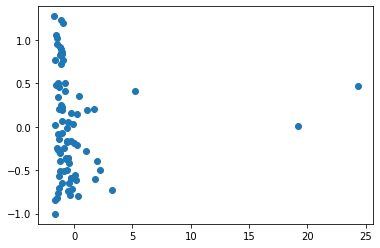

In [61]:
import matplotlib.pyplot as plt
plt.scatter(df_1970_pca[:,0] , df_1970_pca[:,1])
plt.show()

In [62]:
y_kmeans = kmeans.predict(df_1970_pca)

In [63]:
kmeans.cluster_centers_

array([[-6.5978128e-01, -3.8383988e-01],
       [ 2.4356617e+01,  4.6920735e-01],
       [ 2.2693410e+00, -2.1026523e-01],
       [ 1.9247574e+01,  1.3521256e-02],
       [-1.2366041e+00,  6.5572220e-01]], dtype=float32)

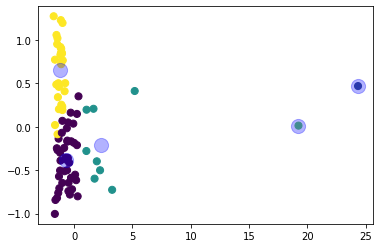

In [66]:
plt.scatter(df_1970_pca[:, 0], df_1970_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='blue', s=200, alpha=0.3)